Populating the interactive namespace from numpy and matplotlib


/home/goios/.pyenv/versions/unsw/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


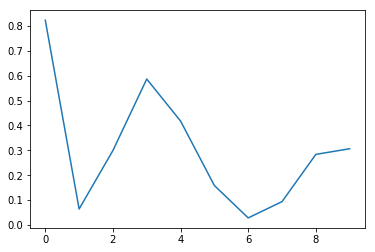

In [21]:
%pylab inline
from copy import deepcopy
from reed_up_downstream_dyn import ReedSimulation, calc_fixed_point
from json_object import JSONObject
from pypevoc.PVAnalysis import PV
from pypevoc.Heterodyne import HeterodyneHarmonic
from pypevoc.SoundUtils import FuncWind
from scipy.optimize import fsolve
import scipy.signal as sig

figure()
plot(rand(10))

In [88]:
with open('tongue_vt_open_simulation_with_tuning.json') as f:
    js = JSONObject(f)
js['environment/blowing pressure/value']=4400
js['environment/blowing pressure/ramp duration']=0.01
js['perturbation/blowing pressure']=4400
js['environment/perturbation time']=0.01
js['simulation/sample rate']=48000#*4
js['simulation/duration']=.1
js['tracts/vocal/frequency independent losses']=0.1
js['tracts/vocal/elements/0/length']=0.03
js['tracts/vocal/elements/0/radius']=0.002
js['tracts/vocal/elements/0/loss multiplier']=5
del js['tracts/vocal/elements/1']
del js['tracts/vocal/elements/1']
js['tracts/vocal/elements/1/length']=0.18
js['environment/frequency dependent losses']=True
js['environment/vocal tract enabled']=True
js['environment/reed/dynamic']=True
js['environment/reed/quality factor']=1.5
js['environment/reed/resonance frequency']=1500
#js['environment/reed/non-linear force/model']='disabled'
js['environment/reed/non-linear force/onset pressure fraction']=.75
#js['environment/reed/stiffness']=500000000.0/4

js.to_python()

{'description': 'Reed simulation with vocal tract and reed dynamics and non-linear reed force',
 'version': '20200320',
 'simulation': {'sample rate': 48000, 'duration': 0.1, 'callback every': 1024},
 'environment': {'acoustic': {'_prefer': True,
   'speed of sound': 346.7492013525034,
   'density': 1.2,
   'viscosity': 1.884e-05},
  'physical': {'atmospheric pressure': 101500,
   'temperature': 36.5,
   'humidity': 100},
  'blowing pressure': {'_comment': "blowing pressure is 'value' from start if ramp not enabled",
   'value': 4400,
   'ramp duration': 0.01,
   '_choices_ramp_type': ['linear', 'exponential'],
   'ramp type': 'exponential',
   'ramp enabled': True},
  'reed': {'_comment': "reed moves instantaneously if 'dynamic' is false, that means res. freq and q are not taken into account",
   'stiffness': 500000000.0,
   'resonance frequency': 1500,
   'quality factor': 1.5,
   'rest opening': 1e-05,
   'dynamic': True,
   'non-linear force': {'_comment': 'non-linear force kicks i

No radiation filter


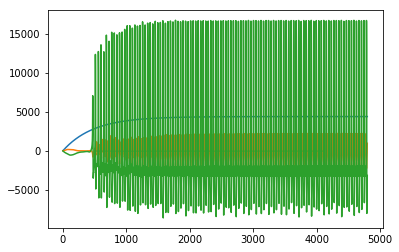

In [89]:
sim = ReedSimulation()
sim.from_json(js)
sim.pert=1.0
sim.set_probe(tract='vocal',tube_nbr=-1,tube_idx=0)
sim.set_probe(tract='vocal',tube_nbr=0,tube_idx=0)
sim.simulate()

figure()
p_b = sim.p_in + sim.p_out;
p_vt = sim.p_vt_in + sim.p_vt_out;

u = (sim.p_out - sim.p_in)/sim.zc_b;
u_sg = -(sim.p_vt_out - sim.p_vt_in)/sim.zc_vt

a = sim.a
plot(sim.p_blow_vec)
lns=plot(p_b)

p_in_avg, t_avg = FuncWind(np.sum,sim.p_in)
p_out_avg, t_avg = FuncWind(np.sum,sim.p_out)
plot(t_avg,p_in_avg+p_out_avg,color=lns[0].get_color(),alpha=.5)
lns=plot(p_vt)

p_vt_in_avg, t_avg = FuncWind(np.sum,sim.p_vt_in)
p_vt_out_avg, t_avg = FuncWind(np.sum,sim.p_vt_out)
plot(t_avg,p_vt_in_avg+p_vt_out_avg,color=lns[0].get_color(),alpha=.5)


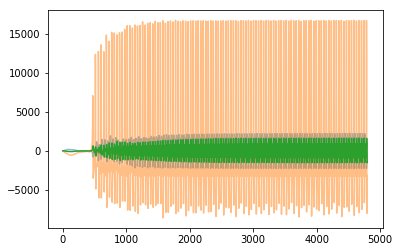

In [93]:
figure()
plot(p_b,alpha=.5)
plot(p_vt,alpha=.5)
p_vt_0 = (np.array(sim.probes[0]['in'])+np.array(sim.probes[0]['out']))
plot(p_vt_0)
#plot((np.array(sim.probes[1]['in'])+np.array(sim.probes[1]['out'])))
#xlim(4000,5000)

(0, 500)

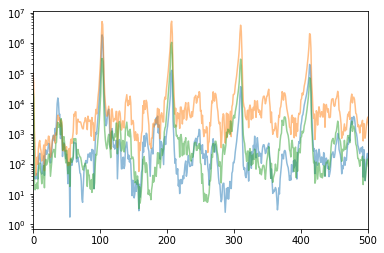

In [92]:
nfft = 2**12
wfun=hanning
p_b_f = np.abs(np.fft.fft(p_b[-nfft:]*wfun(nfft)))
p_vt_f = np.abs(np.fft.fft(p_vt[-nfft:]*wfun(nfft)))
p_vt0_f = np.abs(np.fft.fft(p_vt_0[-nfft:]*wfun(nfft)))


figure()
semilogy(p_b_f,alpha=.5)
semilogy(p_vt_f,alpha=.5)
semilogy(p_vt0_f,alpha=.5)
xlim(0,500)

In [74]:
sim.probes[0]['zc']

1324484.3858020282

In [5]:
p_vt_1 = p_vt
p_b_1 = p_b

In [6]:
figure()
plot(np.arange(len(p_b_1))/48000,p_b_1)
plot(np.arange(len(p_b))/48000,p_b)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [64]:
vt=sim.tracts['vocal']

In [68]:
vt.speed_of_sound

346.7492013525034

In [67]:
vt.radii[0]

0.005

In [9]:
sim.p_vt_in

array([   0.        ,    0.        ,    0.        , ..., -291.44510074,
       -281.39583681, -253.01481389])

In [13]:
tt = vt.tubes[-1]
tt.dump_delays() 

(array([ -79.17164612,  -91.49897672, -100.97910891, -107.30569821,
        -109.24396585, -108.32777443, -109.81105012, -113.52178338,
        -116.30930118, -117.30283748, -114.24516713, -107.9671768 ,
        -111.57268691, -124.93434049, -133.93772994, -140.00372516,
        -141.62207612, -138.16642387]),
 array([ 35.83132366,  31.19588635,  28.65097756,  27.72931594,
         26.64243511,  25.30343817,  24.63283407,  24.97458617,
         26.53244065,  29.91246183,  35.9930166 ,  44.71151368,
         54.74343774,  65.35248981,  76.78187789,  88.72789247,
        100.23757037, 110.33660053]))

In [16]:
tt.dlin.buff

array([ 25.30343817,  24.63283407,  24.97458617,  26.53244065,
        29.91246183,  35.9930166 ,  44.71151368,  54.74343774,
        65.35248981,  76.78187789,  88.72789247, 100.23757037,
       110.33660053,  40.8964606 ,  35.83132366,  31.19588635,
        28.65097756,  27.72931594,  26.64243511,  25.30343817,
        24.63283407,  24.97458617,  26.53244065,  29.91246183,
        35.9930166 ,  44.71151368,  54.74343774,  65.35248981,
        76.78187789,  88.72789247, 100.23757037, 110.33660053,
        40.8964606 ,  35.83132366,  31.19588635,  28.65097756,
        27.72931594,  26.64243511])

In [70]:
sim.rho

1.2

In [7]:
figure()
plot(sim.a)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
figure()
plot(sim.p_blow_vec + p_vt - p_b,u,'.')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [30]:
p=np.arange(-1,6000)
figure()
sim.nlfunc.k2 = sim.a0/10
plot(p,sim.nlfunc(p))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [31]:
sim = ReedSimulation()
sim.from_json(js)

dp_per_samp = 0.5
n_samp=48000
frac = dp_per_samp/js['environment/blowing pressure/value']

pert_pressure = 2100
pert_ampl = 1.01

sim.simulation_init(pert=False)
sim.p_blow=0.0
sim.pert=False
p_blow = []
while sim.samp_no < n_samp:
    sim.simulation_tick(reverse=False)
    if sim.p_blow<pert_pressure:
        sim.p_blow+=(js['environment/blowing pressure/value']-sim.p_blow)*frac
    else:
        if pert_ampl:
            sim.a0*=pert_ampl
            pert_ampl=False
            pert_samp = sim.samp_no
    p_blow.append(sim.p_blow)
sim.finalize()
p_blow= np.array(p_blow)
print("Done")

No radiation filter
Done


In [32]:
figure()
p_b = sim.p_in + sim.p_out;
p_vt = sim.p_vt_in + sim.p_vt_out;

u = (sim.p_out - sim.p_in)/sim.zc_b;
u_sg = -(sim.p_vt_out - sim.p_vt_in)/sim.zc_vt

a = sim.a
lns=plot(p_b)
p_in_avg, t_avg = FuncWind(np.sum,sim.p_in)
p_out_avg, t_avg = FuncWind(np.sum,sim.p_out)
plot(t_avg,p_in_avg+p_out_avg,color=lns[0].get_color(),alpha=.5)

lns=plot(np.array(p_blow)+p_vt)
p_in_avg, t_avg = FuncWind(np.sum,sim.p_vt_in)
p_out_avg, t_avg = FuncWind(np.sum,sim.p_vt_out)
plot(t_avg,p_in_avg+p_out_avg,color=lns[0].get_color(),alpha=.5)

p_shut = sim.k*sim.a0
axhline(p_shut,color='k',ls='--',alpha=.5)
axhline(p_shut/3,color='k',ls='--',alpha=.5)
samp_thr = np.flatnonzero(p_blow>p_shut/3)[0]
axvline(samp_thr,color='k',alpha=.5,ls='--')
axvline(pert_samp,color='r',alpha=.5,ls='--')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
f0=1/(sim.tracts['bore'].total_delay/sim.sr*2)
hhb = HeterodyneHarmonic(p_b,sr=sim.sr,nwind=1024,nhop=256,f=f0)
hhv = HeterodyneHarmonic(p_vt,sr=sim.sr,nwind=1024,nhop=256,f=f0)

In [13]:
figure()
semilogy(hhb.t,np.abs(hhb.camp[:,0]))
semilogy(hhv.t,np.abs(hhv.camp[:,0]))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
close('all')
%pdb off
with open('reed_simulation_dyn_tongue_vt.json') as f:
    js = JSONObject(f)

vtrad=0.01

maxpblow = 2200
n_steps=3
    
js['environment/reed/quality factor']=0.7
js['environment/reed/resonance frequency']=1500 
#js['environment/reed/stiffness']= 500000000.0/10000
js['environment/reed/dynamic']=True
#js['environment/reed/non-linear force/non-linearity']=10

js['tracts/bore/elements/0/length']=0.2
#js['tracts/bore/elements/0/radius']=0.003
js['tracts/vocal/elements/0/length']=0.04
js['tracts/vocal/elements/0/radius']=0.02
js['tracts/vocal/elements/1/length']=0.18
js['tracts/vocal/elements/1/radius']=vtrad
js['tracts/vocal/elements/2/radius']=0.001
tongue_rad = js['tracts/vocal/elements/0/radius']
main_vt_rad = js['tracts/vocal/elements/1/radius']
log_tongue_rad = np.log(tongue_rad)
log_main_vt_rad = np.log(main_vt_rad)

jse = js['tracts/vocal/elements'].copy()

step_len=0.03
cone_len=0

for ii in range(1,len(js['tracts/vocal/elements'])):
    #print(js['tracts/vocal/elements/%d'%(ii)])
    js['tracts/vocal/elements/%d'%(ii+n_steps-1)]=jse[ii].to_python()
    
for ii in range(1,n_steps):
    js['tracts/vocal/elements/%d/radius'%(ii)] = np.exp(log_tongue_rad + (log_main_vt_rad-log_tongue_rad)*ii/n_steps)
    js['tracts/vocal/elements/%d/length'%(ii)] = step_len
    cone_len+=step_len

js['tracts/vocal/elements/%d/length'%(ii+1)] -=cone_len
    
js['perturbation/blowing pressure']=maxpblow*.9
js['environment/blowing pressure/value']=maxpblow


sim = ReedSimulation()
sim.from_json(js)

js.to_python()

Automatic pdb calling has been turned OFF


{'description': 'Reed simulation with open vocal tract and reed dynamics and non-linear reed force',
 'version': '20200423',
 'simulation': {'sample rate': 48000, 'duration': 0.6, 'callback every': 1024},
 'environment': {'acoustic': {'_prefer': True,
   'speed of sound': 346.7492013525034,
   'density': 1.2,
   'viscosity': 1.884e-05},
  'physical': {'atmospheric pressure': 101500,
   'temperature': 36.5,
   'humidity': 100},
  'blowing pressure': {'_comment': "blowing pressure is 'value' from start if ramp not enabled",
   'value': 2200,
   'ramp duration': 0.1,
   '_choices_ramp_type': ['linear', 'exponential'],
   'ramp type': 'exponential',
   'ramp enabled': True},
  'reed': {'_comment': "reed moves instantaneously if 'dynamic' is false, that means res. freq and q are not taken into account",
   'stiffness': 500000000.0,
   'resonance frequency': 1500,
   'quality factor': 0.7,
   'rest opening': 1e-05,
   'dynamic': True,
   'non-linear force': {'_comment': 'non-linear force kic

In [116]:
sim.tracts['bore'].termination

'flanged'

In [117]:
sim = ReedSimulation()
sim.from_json(js)
impresp = sim.tracts['bore'].impulse_response()
figure()
plot(np.arange(len(impresp))/sim.sr,impresp,label='bore')
impresp_vt = sim.tracts['vocal'].impulse_response()
plot(np.arange(len(impresp_vt))/sim.sr,impresp_vt,label='vocal')
legend()

fig,ax=subplots(2,sharex=True)
f = np.arange(len(impresp))/len(impresp)*sim.sr
rf=np.fft.fft(impresp)
z=(1+rf)/(1-rf)*sim.char_impedances['bore']
idx = slice(0,len(f)//2+1)
ax[0].semilogy(f[idx],np.abs(z[idx]))
ax[1].plot(f[idx],np.angle(z[idx]))
rf=np.fft.fft(impresp_vt)
z=(1+rf)/(1-rf)*sim.char_impedances['vocal']
ax[0].semilogy(f[idx],np.abs(z[idx]))
ax[1].plot(f[idx],np.angle(z[idx]))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

No radiation filter


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [15]:
sim = ReedSimulation()
sim.from_json(js)
sim.simulate()

No radiation filter
applied perturbation at sample 11051 (P_blow=1980.0340498607563)


In [16]:
figure()
p_b = sim.p_in + sim.p_out;
p_vt = sim.p_vt_in + sim.p_vt_out;

u = (sim.p_out - sim.p_in)/sim.zc_b;
u_sg = -(sim.p_vt_out - sim.p_vt_in)/sim.zc_vt

a = sim.a
lns=plot(p_b)
p_in_avg, t_avg = FuncWind(np.sum,sim.p_in)
p_out_avg, t_avg = FuncWind(np.sum,sim.p_out)
plot(t_avg,p_in_avg+p_out_avg,color=lns[0].get_color(),alpha=.5)

lns=plot(np.array(sim.p_blow_vec)+p_vt)
#lns=plot(p_vt)
p_in_avg, t_avg = FuncWind(np.sum,sim.p_vt_in)
p_out_avg, t_avg = FuncWind(np.sum,sim.p_vt_out)
plot(t_avg,p_in_avg+p_out_avg,color=lns[0].get_color(),alpha=.5)

p_shut = sim.k*sim.a0
axhline(p_shut,color='k',ls='--',alpha=.5)
axhline(p_shut/3,color='k',ls='--',alpha=.5)
try:
    samp_thr = np.flatnonzero(np.array(sim.p_blow_vec)>p_shut/3)[0]
    axvline(samp_thr,color='k',alpha=.5,ls='--')
    axhline(sim.pert_p_blow,color='r',alpha=.5,ls='--')
except IndexError:
    pass
    
figure()
dpt = np.linspace(np.min(sim.p_blow+p_vt-p_b),np.max(sim.p_blow+p_vt-p_b),200)
plot(sim.p_blow+p_vt-p_b,u,'.',alpha=.2)
plot(dpt,np.vectorize(sim.puchar)(dpt,dynamic=False))

figure()
plot(sim.p_blow+p_vt-p_b,sim.a,'.',alpha=.2)
plot(dpt,np.vectorize(sim.reed_opening)(dpt,dynamic=False))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
fig,ax=subplots(4,sharex=True)
ax[0].plot(sim.a*1e6)
ax[0].set_ylabel('Reed opening\n(mm2)')
ax[1].plot(p_b/1000,label='bore')
ax[1].plot((np.array(sim.p_blow_vec)+p_vt)/1000,label='vocal')
ax[1].set_ylabel('Pressure\n(kPa)')
ax[1].legend()
ax[2].plot(sim.p_out/1000,label='p+, bore')
ax[2].plot(sim.p_in/1000,label='p-, bore')
ax[2].plot(sim.p_vt_out/1000,label='p+, vocal')
ax[2].plot(sim.p_vt_in/1000,label='p-, vocal')
ax[2].set_ylabel('Pressure\nwaves\n(kPa)')
ax[2].legend()

ax[3].plot(u*1e6)
ax[3].plot(u_sg*1e6)
ax[3].set_ylabel('Flow\n(cm3/s)')
tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
f0=1/(sim.tracts['bore'].total_delay/sim.sr*2)

nfft=1024
figure()
x = p_b[-nfft:]
xf = np.fft.fft(x)
f = np.linspace(0,sim.sr,nfft+1)[:nfft]
semilogy(f,np.abs(xf))
axvline(f0,color='r')
relmaxidx = sig.argrelmax(np.abs(xf),order=int(f0/sim.sr*len(f)/2))[0]
ridx = np.argmin(np.abs(f[relmaxidx]-f0))
f0r = f[relmaxidx[ridx]]
axvline(f0r,color='m')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [122]:
hhb = HeterodyneHarmonic(p_b,sr=sim.sr,nwind=1024//2,nhop=256*2,f=f0r,nharm=6)
hhv = HeterodyneHarmonic(p_vt,sr=sim.sr,nwind=1024//2,nhop=256*2,f=f0r,nharm=6)
fig,ax=subplots(2,sharex=True)
ax[0].semilogy(hhb.t,np.abs(hhb.camp[:,0]))
ax[0].semilogy(hhv.t,np.abs(hhv.camp[:,0]))
ax[1].semilogy(hhb.t,np.abs(hhb.camp[:,0])/np.abs(hhv.camp[:,0]))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [123]:
figure()
for ii in range(hhb.camp.shape[1]):
    lns=semilogy(hhv.t,np.abs(hhv.camp[:,ii]),label='pvt H%d'%(ii+1))
    semilogy(hhv.t,np.abs(hhb.camp[:,ii]),alpha=.5,ls='--',color=lns[0].get_color(),label='pb H%d'%(ii+1))
legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [141]:
tongdict={}

tongue_rad_list=[0.02,0.015,0.01,0.005,0.003,0.0015]


for tongue_rad in tongue_rad_list:
    sim = ReedSimulation()
    #tongue_rad = js['tracts/vocal/elements/0/radius']
    main_vt_rad = js['tracts/vocal/elements/1/radius']
    log_tongue_rad = np.log(tongue_rad)

    #cone_len = 0    
    for ii in range(0,n_steps):
        js['tracts/vocal/elements/%d/radius'%(ii)] = np.exp(log_tongue_rad + (log_main_vt_rad-log_tongue_rad)*ii/n_steps)
        #js['tracts/vocal/elements/%d/length'%(ii)] = step_len
        cone_len+=step_len

    #js['tracts/vocal/elements/%d/length'%(ii+1)] -=cone_len
    
    sim.from_json(js)
    impresp = sim.tracts['bore'].impulse_response()
    impresp_vt = sim.tracts['vocal'].impulse_response()
    zch_b = sim.char_impedances['bore']
    zch_vt = sim.char_impedances['vocal']

    sim = ReedSimulation()
    #js['tracts/vocal/elements/0/radius']=tongue_rad
    sim.from_json(js)
    sim.simulate()
    
    p_b = sim.p_in + sim.p_out;
    p_vt = sim.p_vt_in + sim.p_vt_out;

    u = (sim.p_out - sim.p_in)/sim.zc_b;
    u_sg = -(sim.p_vt_out - sim.p_vt_in)/sim.zc_vt

    a = sim.a
    f0=1/(sim.tracts['bore'].total_delay/sim.sr*2)
    hhb = HeterodyneHarmonic(p_b,sr=sim.sr,nwind=1024,nhop=256,f=f0)
    hhv = HeterodyneHarmonic(p_vt,sr=sim.sr,nwind=1024,nhop=256,f=f0)

    this_dict = {'p_b':p_b,'p_vt':p_vt,'hhb':hhb,'hhv':hhv,'pert_time':sim.pert_time,'p_blow':sim.p_blow_vec,
                 'impresp_b':impresp, 'impresp_vt':impresp_vt, 'zch_b':zch_b, 'zch_vt':zch_vt}
    tongdict[tongue_rad]=this_dict

No radiation filter
No radiation filter
applied perturbation at sample 11051 (P_blow=1980.0340498607563)
No radiation filter
No radiation filter
applied perturbation at sample 11051 (P_blow=1980.0340498607563)
No radiation filter
No radiation filter
applied perturbation at sample 11051 (P_blow=1980.0340498607563)
No radiation filter
No radiation filter
applied perturbation at sample 11051 (P_blow=1980.0340498607563)
No radiation filter
No radiation filter
applied perturbation at sample 11051 (P_blow=1980.0340498607563)
No radiation filter
No radiation filter
applied perturbation at sample 11051 (P_blow=1980.0340498607563)


In [142]:
nrows = int(np.sqrt(len(tongdict)))
ncols = int(np.ceil(len(tongdict)/nrows))

fig,ax = subplots(nrows,ncols,sharex=True,sharey=True)

axf = ax.flatten()

for ii,(tongrad,sigdict) in enumerate(tongdict.items()):
    t = np.arange(len(sigdict['p_b']))/sim.sr - sigdict['pert_time']
    axf[ii].plot(t,sigdict['p_b'])
    axf[ii].plot(t,sigdict['p_vt'])
    axf[ii].set_title(tongrad)

/home/goios/.pyenv/versions/unsw/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [143]:
len(tongdict)

6

In [144]:
nrows = int(np.sqrt(len(tongdict)))
ncols = int(np.ceil(len(tongdict)/nrows))

for hno in [0,2]:
    fig,ax = subplots(nrows,ncols,sharex=True,sharey=True)

    axf = ax.flatten()

    for ii,(tongrad,sigdict) in enumerate(tongdict.items()):
        f0=1/(sim.tracts['bore'].total_delay/sim.sr*2)

        nfft=1024
        p_b = sigdict['p_b']
        p_vt = sigdict['p_vt']
        x = p_b[-nfft:]
        xf = np.fft.fft(x)
        f = np.linspace(0,sim.sr,nfft+1)[:nfft]
        relmaxidx = sig.argrelmax(np.abs(xf))[0]
        ridx = np.argmin(np.abs(f[relmaxidx]-f0))
        f0r = f[relmaxidx[ridx]]
        hh = HeterodyneHarmonic(p_b,sr=sim.sr,nwind=1024,nhop=256,f=f0r)
        sigdict['hhb']=hh
        axf[ii].semilogy(hh.t-sigdict['pert_time'],np.abs(hh.camp[:,hno]))
        hh = HeterodyneHarmonic(p_vt,sr=sim.sr,nwind=1024,nhop=256,f=f0r)
        sigdict['hhv']=hh
        axf[ii].semilogy(hh.t-sigdict['pert_time'],np.abs(hh.camp[:,hno]))
        axf[ii].set_title(tongrad)

/home/goios/.pyenv/versions/unsw/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/goios/.pyenv/versions/unsw/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [145]:
prats=[]
pratsus=[]
for ii,(tongrad,sigdict) in enumerate(tongdict.items()):
    hhb = sigdict['hhb']
    hhv = sigdict['hhv']
    henv = np.abs(hhb.camp[:,0])
    hfinal = np.median(henv[-5:])
    itend = np.flatnonzero(henv>hfinal/2)[0]
    itst = np.flatnonzero(hhb.t>sigdict['pert_time'])[0]
    if itst>itend:
        itst = np.argmin(henv[:itend])
        itst += np.flatnonzero(henv[itst:]>hfinal/1000)[0]
                
    print(tongrad, hfinal, itst,itend)
    prats.append(np.median(np.abs(hhv.camp[itst:itend,0])/np.abs(hhb.camp[itst:itend,0])))
    pratsus.append(np.median(np.abs(hhv.camp[itend:,0])/np.abs(hhb.camp[itend:,0])))
    
figure()
plot(tongue_rad_list,20*np.log10(prats),'o-',label='transient')
plot(tongue_rad_list,20*np.log10(pratsus),'o-',label='sustain')

xlabel('tongue radius')
ylabel('vocal tract H1 / bore H1')
legend()

0.02 1013.3130059014375 42 75
0.015 1637.9812877285426 42 79
0.01 2061.6289025046353 42 80
0.005 2205.514604763396 42 70
0.003 1972.4578569435625 42 57
0.0015 137.33439625409773 42 65


/home/goios/.pyenv/versions/unsw/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [146]:
fig,ax=subplots(2,sharex=True)
alpha=.3
for ii,(tongrad,sigdict) in enumerate(tongdict.items()):
    impresp_b = sigdict['impresp_b']
    impresp_vt = sigdict['impresp_vt']
    f = np.arange(len(impresp_vt))/len(impresp_vt)*sim.sr

    rf=np.fft.fft(impresp_vt)
    z=(1+rf)/(1-rf)*sigdict['zch_vt']
    ax[0].semilogy(f,np.abs(z),alpha=alpha,label=tongrad)
    ax[1].plot(f,np.angle(z),alpha=alpha)

rf=np.fft.fft(impresp_b)
z_b=(1+rf)/(1-rf)*sigdict['zch_b']
ax[0].semilogy(f,np.abs(z_b),color='k',label='bore')
ax[1].plot(f,np.angle(z_b),color='k')
ax[0].set_xlim(0,4000)
ax[0].legend(bbox_to_anchor=(1,1),loc='upper left')
tight_layout()

/home/goios/.pyenv/versions/unsw/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [147]:
js.to_python()

{'description': 'Reed simulation with vocal tract and reed dynamics and non-linear reed force',
 'version': '20200320',
 'simulation': {'sample rate': 48000, 'duration': 0.6, 'callback every': 1024},
 'environment': {'acoustic': {'_prefer': True,
   'speed of sound': 346.7492013525034,
   'density': 1.2,
   'viscosity': 1.884e-05},
  'physical': {'atmospheric pressure': 101500,
   'temperature': 36.5,
   'humidity': 100},
  'blowing pressure': {'_comment': "blowing pressure is 'value' from start if ramp not enabled",
   'value': 2200,
   'ramp duration': 0.1,
   '_choices_ramp_type': ['linear', 'exponential'],
   'ramp type': 'exponential',
   'ramp enabled': True},
  'reed': {'_comment': "reed moves instantaneously if 'dynamic' is false, that means res. freq and q are not taken into account",
   'stiffness': 500000000.0,
   'resonance frequency': 1500,
   'quality factor': 0.7,
   'rest opening': 1e-05,
   'dynamic': True,
   'non-linear force': {'_comment': 'non-linear force kicks in